In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.extmath import safe_sparse_dot

import metrics

In [2]:
np.set_printoptions(suppress=True)
tqdm.pandas()

### Load and process data

In [3]:
df = pd.read_csv('data/records25k_data.tsv', sep='\t', header=None)
df.columns = ['name1', 'name2', 'co_occurrence', 'count1', 'count2']
df.dropna(inplace=True)

In [4]:
df_name_matches = df.groupby('name1')['name2'].agg(list).reset_index()
all_candidates = np.array(list(set(df['name2'].tolist())))
relevants = df_name_matches['name2'].tolist()

### Model

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char_wb', min_df=10)

In [6]:
X = vectorizer.fit_transform(all_candidates)

#### Similarity Function

In [7]:
def get_similars(name, k=10):
    x = vectorizer.transform([name]).toarray()
    scores = safe_sparse_dot(X, x.T).flatten()
    sorted_scores_idx = np.argsort(scores)[::-1][:k]
    candidates = all_candidates[sorted_scores_idx]
    candidates_scores = scores[sorted_scores_idx]
    
    return list(zip(candidates, candidates_scores))

#### Demo

In [8]:
get_similars('schumacher', 10)

[('schumacker', 0.8059985234265264),
 ('schuman', 0.756839107248047),
 ('schumann', 0.7077021140101964),
 ('schumaker', 0.6847740825173084),
 ('schum', 0.6573763863379664),
 ('schacher', 0.6480792733078763),
 ('scheuman', 0.5625756004447104),
 ('hamacher', 0.5537141511649946),
 ('amacher', 0.5511968006121096),
 ('schuk', 0.527669502986254)]

### Generate candidates for all names

In [9]:
k = 100 # Number of candidates
name_candidates = df_name_matches['name1'].progress_apply(get_similars, k=k)
candidates = np.array(name_candidates.tolist())[:,:, 0]

100%|██████████| 23587/23587 [01:09<00:00, 340.20it/s]


### Evaluation

In [10]:
def precision_recall(relevants, candidates, N):
    precisions = []
    recalls = []
    for i in range(N):
        precisions.append(np.mean([metrics.precision_k(a, c, i + 1) for a, c in zip(relevants, candidates)]))
        recalls.append(np.mean([metrics.recall_k(a, c, i + 1) for a, c in zip(relevants, candidates)]))
    return precisions, recalls

### mAP@1

In [11]:
metrics.mean_avg_precision_k(relevants, candidates, 1)

0.4694111162928732

### mAP@3

In [12]:
metrics.mean_avg_precision_k(relevants, candidates, 3)

0.3909474616431838

### Precision-Recall Curve

In [13]:
# Number of rank cutoffs to test i.e precision_{i}, recall_{i} for i in (1, ..., N)
N = 100
precisions, recalls = precision_recall(relevants, candidates, N)

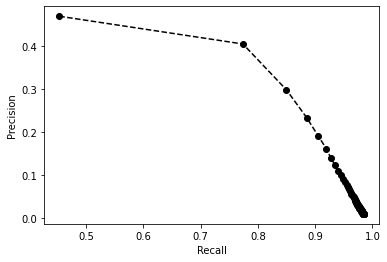

In [14]:
plt.plot(recalls, precisions, 'ko--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()